In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, lfilter
from scipy.signal import butter, lfilter
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


In [2]:
#data_url = 'https://raw.githubusercontent.com/Rjlmota/physiobank_getter/master/ecgiddb/per_person/person1.csv'
#data = pd.read_csv(data_url)
ecg_data = pd.read_csv('physiobank_tool/drivedb/drive03.csv', usecols=[0, 1, 2])
ecg_data = ecg_data.drop(ecg_data.index[0])
ecg_data.columns = ['time', 'ECG', 'ECGF']
#ecg_data.index.total_seconds
ecg_data['time'] = ecg_data['time'].astype(float)
ecg_data.head(2)

/home/renato/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


time    ECG   ECGF
1  0.000  0.000  0.000
2  0.002  0.000  0.000

In [3]:
#FILTERING FUNCTIONS
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

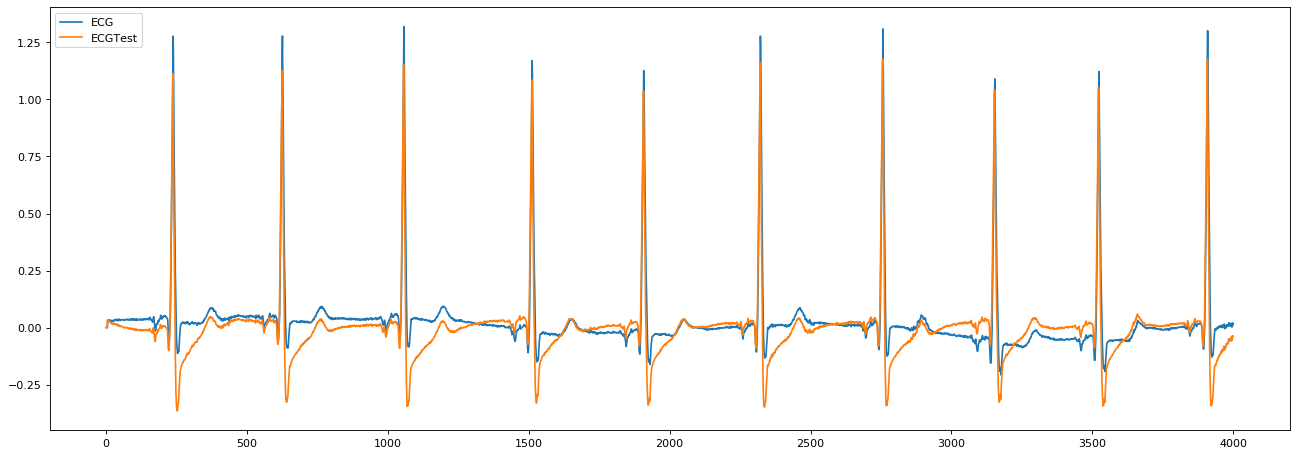

In [11]:
#teste = normalize_segment(ecg_data['ECG'][0:1000])


fig=plt.figure(figsize=(20, 7), dpi= 80, facecolor='w', edgecolor='k')

n_samples = 4000
ecg_data['ECG'] = ecg_data['ECG'].astype(float)

#plt.plot(ecg_data['ECGF'][0:n_samples], label="ECG")
plt.plot(ecg_data['ECG'][0:n_samples], label='ECG')
resultado = butter_bandpass_filter(ecg_data['ECG'][0:n_samples], 2, 999, 2000.0, order=6)
plt.plot(resultado, label='ECGTest')
plt.savefig("oi.jpg")
plt.legend()

In [6]:
class Filter(BaseEstimator, TransformerMixin):
    def __init__(self, sample_rate, low_cut, high_cut, order = 5):
        self.sample_rate = sample_rate
        self.low_cut = low_cut
        self.high_cut = high_cut
        self.order = order
        
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        self.X = X
        return butter_bandpass_filter(self.X, self.low_cut, self.high_cut, self.sample_rate, self.order)
    

class Segmentator(BaseEstimator, TransformerMixin):
    def __init__(self, number_of_segments, sample_rate):
        self.number_of_segments = number_of_segments
        self.sample_rate = sample_rate
        
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.X = X
        return self.segmentate()
      
            
            
    def segmentate(self):
        # armazenará as features extraídas
        
        columns_names = ['mean_q', 'mean_r', 'mean_s',
                         'stdev_q', 'stdev_r','stdev_s',
                         'qrs_interval', 'rr_interval','rq_amplitude', 'qrs_interval'] # peaks number as a feature later?
    
        self.features_df = pd.DataFrame(columns=columns_names)
        
        # pega todos os segmentos originais possíveis de se obter com os dados originais
        # e extrai as features de cada segmento desses
        segment_counter = 0
        
        step = self.sample_rate*2
        for time_window in range(step, len(self.X), step):
            segment = self.X[time_window-step:time_window]
            extracted_features = self.extract_features(segment)
            #print(extracted_features)
            #print()
            self.features_df.loc[segment_counter] = extracted_features
            segment_counter += 1
            
        # define quantos segmentos aleatórios serão gerados:
        n_of_missing_segments = self.number_of_segments - len(self.features_df)
        
        print(f"generated {segment_counter} original segments")
        # gera os segmentos aleatórios, e extrai as features de cada segmento desses
        for index in range(0,n_of_missing_segments):
            # gera o segmento aleatóprio aqui
            random_segment = self.random_segment_generator()
            #print("AAA:", random_segment)
            extracted_features = self.extract_features(random_segment)
            # adiciona o segmento aeatório no dataframe final
            self.features_df.loc[segment_counter] = extracted_features
            segment_counter += 1
        
        print(f"generated {segment_counter} final segments")

    
        return self.features_df
    
    def random_segment_generator(self): 
        window = 500*2
        # index menor
        cap = len(self.X) - (window) -1


        initial_index = np.random.randint(cap)
        # index maior
        final_index = initial_index + window
        # pegar a janela aleatoria
        #print(self.X[initial_index:final_index])
        #input()
        return np.array(self.X[initial_index:final_index])

    
    
    
    def extract_features(self, segment):
        '''
        Extracts the peak's indexes based on a time distance based on the predefined sample rate.

        Returns:
        features list containing the following information:

        (meanQ, meanR, mmeanS, deltaR, stdevQ, stdevR, stdevS
        qrs_interval, rr_interval, rq_amplitude) + number_of_peaks? 
        '''
        max_value = np.max(np.array(segment).astype(float))
        #print("A:", type(max_value))
        peaks, _ = find_peaks(segment, height=0.6*max_value, distance=500*0.2)
        q_list = []
        s_list = []
        r_list = []
        qrs_interval_list = []
        rq_amplitude_list = []
        # initiates output tuple
        features = []


        if(len(peaks) < 1):
            return None

        if(peaks[-1] + 500*0.040 > len(segment)):
            peaks = np.delete(peaks, [len(peaks)-1])

        if(len(peaks) < 1):
            return None
        if(peaks[0] -500*0.040 < 0):
            peaks = np.delete(peaks, [0])

        if(len(peaks) < 1):
            return None
        #finding difference between r times
        difference_between_r = np.diff(peaks)
        rr_interval = np.mean(difference_between_r)*(1000.0/float(500)) #interval in ms corresponding to each dataset's time unit

        #print(peaks)

        for peak in peaks:
            # this search windows surround the R peak found before by 40ms,
            # which is enough for detecting the said features
            step = int(500*0.040)
            search_window = segment[peak-step:peak+step]
            half_index = int(len(search_window)//2)


            # finding q:
            q_value = min(search_window[:half_index])
            q_list.append(q_value)
            q_instant_time = search_window[:half_index].argmin()


            # finding s:
            s_value = min(search_window[half_index:])
            s_list.append(s_value)
            s_instant_time = search_window[half_index:].argmin()

            #defing qrs interval
            qrs_interval = ( (s_instant_time+step) - q_instant_time) * (1000.0/float(500))
            qrs_interval_list.append(qrs_interval)


            #obtaining rq_amplitude
            rq_amplitude = abs(segment[peak] - q_value)
            #print("TESTE:", rq_amplitude)
            rq_amplitude_list.append(rq_amplitude)




        r_list = [segment[index] for index in peaks]

        mean_q = np.mean(q_list)
        mean_s = np.mean(s_list)
        mean_r = np.mean(r_list)

        stdev_q = np.std(q_list)
        stdev_s = np.std(s_list)
        stdev_r = np.std(r_list)

        mean_rq_amplitude = np.mean(rq_amplitude_list)
        mean_qrs_interval = np.mean(qrs_interval_list)


        diff_r = np.diff(peaks)
        deltaR = 0 if(len(diff_r) == 0) else np.mean(diff_r)

        return [mean_q, mean_r, mean_s, stdev_q,
                stdev_r, stdev_s, mean_qrs_interval, rr_interval,
                mean_rq_amplitude, mean_qrs_interval]

In [7]:
data_preparation_pipeline = Pipeline([
    ('filtering', Filter(500, 0.1, 125)),
    ('feature_detection', Segmentator(1900, 500)),
    #'std_scaler', StandardScaler())
    ])

In [8]:
teste = extracted_features_df = data_preparation_pipeline.fit_transform(ecg_data['ECG'])

generated 19 original segments


/home/renato/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/renato/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


generated 1900 final segments


In [9]:
print(teste)

        mean_q    mean_r    mean_s   stdev_q   stdev_r   stdev_s  \
0    -0.167353  0.863052 -0.415413  0.158030  0.107970  0.188840   
1    -0.076416  1.043052 -0.319383  0.076883  0.070487  0.073448   
2     0.015514  0.833648 -0.218050  0.175447  0.168167  0.206061   
3    -0.262120  0.740881 -0.560882  0.049588  0.070671  0.037076   
4    -0.246369  0.718043 -0.525936  0.019334  0.123979  0.043569   
5    -0.181034  0.857593 -0.441165  0.008863  0.087459  0.025020   
6    -0.167836  0.686998 -0.469846  0.017102  0.069667  0.019429   
7    -0.225091  0.684524 -0.470623  0.032942  0.089910  0.034685   
8    -0.202614  0.722697 -0.476245  0.006061  0.045401  0.009445   
9    -0.204475  0.741047 -0.468451  0.001895  0.085568  0.054803   
10   -0.183815  0.647644 -0.472777  0.027222  0.091913  0.052664   
11   -0.114547  0.573720 -0.386150  0.093795  0.110266  0.165999   
12   -0.202201  0.721457 -0.456564  0.025744  0.053368  0.014589   
13   -0.137428  0.600041 -0.400738  0.065752  0.

In [10]:
def random_segment_generator(X): 
    window = 500*2
    # index menor
    cap = len(X) - (window) -1


    initial_index = np.random.randint(cap)
    # index maior
    final_index = initial_index + window
    # pegar a janela aleatoria
    #print(self.X[initial_index:final_index])
    #input()
    return np.array(X[initial_index:final_index])

def extract_features(segment):
    '''
    Extracts the peak's indexes based on a time distance based on the predefined sample rate.

    Returns:
    features list containing the following information:

    (meanQ, meanR, mmeanS, deltaR, stdevQ, stdevR, stdevS
    qrs_interval, rr_interval, rq_amplitude) + number_of_peaks? 
    '''
    max_value = np.max(np.array(segment).astype(float))
    #print("A:", type(max_value))
    peaks, _ = find_peaks(segment, height=0.6*max_value, distance=500*0.2)
    q_list = []
    s_list = []
    r_list = []
    qrs_interval_list = []
    rq_amplitude_list = []
    # initiates output tuple
    features = []


    
    if(peaks[-1] + 500*0.040 > len(segment)):
        peaks = np.delete(peaks, [len(peaks)-1])
    
    if(len(peaks) < 1):
        return None
    if(peaks[0] -500*0.040 < 0):
        peaks = np.delete(peaks, [0])
    
    if(len(peaks) < 1):
        return None
    #finding difference between r times
    difference_between_r = np.diff(peaks)
    rr_interval = np.mean(difference_between_r)*(1000.0/float(500)) #interval in ms corresponding to each dataset's time unit

    #print(peaks)

    for peak in peaks:
        # this search windows surround the R peak found before by 40ms,
        # which is enough for detecting the said features
        step = int(500*0.040)
        search_window = segment[peak-step:peak+step]
        half_index = int(len(search_window)//2)


        # finding q:
        q_value = min(search_window[:half_index])
        q_list.append(q_value)
        q_instant_time = search_window.argmin()


        # finding s:
        s_value = min(search_window[half_index:])
        s_list.append(s_value)
        s_instant_time = search_window.argmin()

        #defing qrs interval
        qrs_interval = ( (s_instant_time+step) - q_instant_time) * (1000.0/float(500))
        qrs_interval_list.append(qrs_interval)


        #obtaining rq_amplitude
        rq_amplitude = abs(segment[peak] - q_value)
        rq_amplitude_list.append(rq_amplitude)




    r_list = [segment[index] for index in peaks]

    mean_q = np.mean(q_list)
    mean_s = np.mean(s_list)
    mean_r = np.mean(r_list)

    stdev_q = np.std(q_list)
    stdev_s = np.std(s_list)
    stdev_r = np.std(r_list)

    mean_rq_amplitude = np.mean(rq_amplitude_list)
    mean_qrs_interval = np.mean(qrs_interval_list)


    diff_r = np.diff(peaks)
    deltaR = 0 if(len(diff_r) == 0) else np.mean(diff_r)

    return [mean_q, mean_r, mean_s, stdev_q,
            stdev_r, stdev_s, rr_interval,
            mean_rq_amplitude, mean_qrs_interval]

In [11]:
for i in range(1000):
    sseg = random_segment_generator(ecg_data['ECG'])
    print(sseg)
    extract_features(sseg)

[-0.13  -0.045 -0.17  -0.325 -0.32  -0.275 -0.27  -0.005  0.08  -0.035
 -0.06  -0.165 -0.265 -0.305 -0.245 -0.32  -0.175 -0.04  -0.055 -0.035
 -0.015 -0.13  -0.265 -0.245 -0.205 -0.295 -0.185 -0.13  -0.01  -0.07
 -0.025 -0.125 -0.225 -0.205 -0.3   -0.335 -0.19  -0.005 -0.04  -0.03
 -0.085 -0.125 -0.31  -0.325 -0.375 -0.27  -0.26   0.065 -0.005 -0.02
 -0.165 -0.145 -0.32  -0.265 -0.265 -0.23  -0.04  -0.07  -0.055 -0.12
 -0.165 -0.21  -0.29  -0.215 -0.25  -0.285 -0.08  -0.045 -0.005  0.05
 -0.025 -0.185 -0.29  -0.31  -0.31  -0.285 -0.105  0.02   0.055 -0.04
 -0.065 -0.17  -0.19  -0.215 -0.295 -0.195 -0.07  -0.11  -0.06  -0.075
 -0.15  -0.235 -0.19  -0.235 -0.21  -0.215 -0.24  -0.09  -0.045  0.
 -0.125 -0.17  -0.3   -0.435 -0.2   -0.15  -0.055 -0.06   0.05   0.045
 -0.13  -0.22  -0.26  -0.355 -0.27  -0.195 -0.09  -0.075  0.01   0.
 -0.1   -0.255 -0.25  -0.335 -0.22  -0.095 -0.1   -0.085  0.025 -0.125
 -0.195 -0.035 -0.07  -0.05   0.05   0.235  0.24   0.495  0.655  0.545
  0.355  0.155  0.

[-0.265 -0.245 -0.29  -0.195 -0.01   0.105  0.025 -0.07  -0.005 -0.19
 -0.315 -0.27  -0.25  -0.1   -0.06  -0.035 -0.005 -0.095 -0.13  -0.225
 -0.305 -0.27  -0.2   -0.185 -0.09  -0.035 -0.035  0.03  -0.07  -0.23
 -0.265 -0.285 -0.285 -0.15   0.065 -0.045 -0.095 -0.09  -0.16  -0.29
 -0.245 -0.17  -0.245 -0.125 -0.115 -0.105 -0.025 -0.065 -0.11  -0.275
 -0.265 -0.28  -0.11  -0.145  0.05   0.01   0.185  0.105  0.11  -0.07
  0.015  0.085  0.215  0.385  0.51   0.475  0.285  0.095  0.    -0.09
 -0.165 -0.395 -0.49  -0.285 -0.245 -0.31  -0.36  -0.325 -0.575 -0.565
 -0.485 -0.46  -0.35  -0.155 -0.155 -0.17  -0.105  0.03  -0.225 -0.34
 -0.295 -0.225 -0.17  -0.015 -0.07   0.02   0.205 -0.02  -0.185 -0.225
 -0.09  -0.24  -0.175  0.05   0.09   0.085 -0.03  -0.115 -0.13  -0.17
 -0.265 -0.28  -0.11   0.045  0.075  0.005 -0.035  0.09  -0.065 -0.07
 -0.44  -0.165 -0.065 -0.01   0.09   0.08   0.095 -0.005 -0.01  -0.195
 -0.08  -0.11   0.01   0.06   0.115  0.095 -0.005 -0.045 -0.275 -0.22
 -0.095 -0.055 

[-0.24  -0.28  -0.335 -0.255 -0.2    0.025  0.    -0.14  -0.13  -0.045
 -0.17  -0.325 -0.32  -0.275 -0.27  -0.005  0.08  -0.035 -0.06  -0.165
 -0.265 -0.305 -0.245 -0.32  -0.175 -0.04  -0.055 -0.035 -0.015 -0.13
 -0.265 -0.245 -0.205 -0.295 -0.185 -0.13  -0.01  -0.07  -0.025 -0.125
 -0.225 -0.205 -0.3   -0.335 -0.19  -0.005 -0.04  -0.03  -0.085 -0.125
 -0.31  -0.325 -0.375 -0.27  -0.26   0.065 -0.005 -0.02  -0.165 -0.145
 -0.32  -0.265 -0.265 -0.23  -0.04  -0.07  -0.055 -0.12  -0.165 -0.21
 -0.29  -0.215 -0.25  -0.285 -0.08  -0.045 -0.005  0.05  -0.025 -0.185
 -0.29  -0.31  -0.31  -0.285 -0.105  0.02   0.055 -0.04  -0.065 -0.17
 -0.19  -0.215 -0.295 -0.195 -0.07  -0.11  -0.06  -0.075 -0.15  -0.235
 -0.19  -0.235 -0.21  -0.215 -0.24  -0.09  -0.045  0.    -0.125 -0.17
 -0.3   -0.435 -0.2   -0.15  -0.055 -0.06   0.05   0.045 -0.13  -0.22
 -0.26  -0.355 -0.27  -0.195 -0.09  -0.075  0.01   0.    -0.1   -0.255
 -0.25  -0.335 -0.22  -0.095 -0.1   -0.085  0.025 -0.125 -0.195 -0.035
 -0.07  -0.

[-0.07   0.     0.03  -0.11  -0.065 -0.24  -0.275 -0.23  -0.335 -0.215
 -0.085  0.09   0.095 -0.015 -0.125 -0.1   -0.36  -0.24  -0.21  -0.24
 -0.105 -0.055  0.065 -0.05  -0.175 -0.22  -0.225 -0.34  -0.34  -0.185
 -0.125  0.02  -0.015 -0.02  -0.08  -0.255 -0.26  -0.39  -0.225 -0.225
 -0.13  -0.06  -0.07  -0.055 -0.135 -0.32  -0.33  -0.31  -0.405 -0.205
  0.1   -0.115 -0.04  -0.06  -0.045 -0.295 -0.24  -0.32  -0.255 -0.17
  0.035  0.03   0.095  0.195  0.07   0.115  0.04   0.095  0.42   0.505
  0.5    0.58   0.505  0.195 -0.07  -0.105 -0.255 -0.415 -0.445 -0.46
 -0.465 -0.27  -0.285 -0.405 -0.485 -0.51  -0.59  -0.45  -0.44  -0.285
 -0.135 -0.085 -0.145 -0.13  -0.08  -0.24  -0.385 -0.335 -0.26  -0.135
  0.     0.025  0.055 -0.02  -0.185 -0.335 -0.325 -0.21  -0.235 -0.15
 -0.015  0.08  -0.03   0.075 -0.12  -0.15  -0.235 -0.21  -0.26  -0.09
  0.015 -0.055 -0.04   0.05  -0.05  -0.315 -0.37  -0.28  -0.205  0.075
  0.065  0.025  0.065  0.075 -0.16  -0.24  -0.225 -0.13  -0.13  -0.015
  0.03   0.

[ 0.38   0.55   0.335  0.3    0.31   0.325  0.43   0.64   0.78   0.975
  1.055  1.015  0.79   0.635  0.38   0.255  0.22   0.145  0.15   0.055
  0.055  0.005 -0.01  -0.03  -0.14  -0.215 -0.15  -0.085  0.04   0.21
  0.235  0.235  0.255  0.085  0.175  0.065 -0.07   0.145  0.275  0.355
  0.36   0.315  0.275  0.245  0.095  0.03   0.17   0.155  0.32   0.445
  0.395  0.37   0.31   0.16   0.19   0.11   0.18   0.21   0.295  0.37
  0.47   0.45   0.195  0.125  0.15   0.13   0.185  0.285  0.405  0.44
  0.31   0.305  0.43   0.185  0.155  0.23   0.255  0.3    0.41   0.25
  0.445  0.36   0.32   0.26   0.15   0.165  0.21   0.195  0.435  0.545
  0.48   0.455  0.455  0.23   0.22   0.18   0.3    0.325  0.52   0.41
  0.47   0.405  0.43   0.44   0.345  0.31   0.36   0.395  0.56   0.6
  0.645  0.565  0.495  0.315  0.3    0.33   0.405  0.5    0.69   0.585
  0.645  0.545  0.57   0.31   0.265  0.265  0.37   0.57   0.585  0.56
  0.62   0.54   0.375  0.23   0.135  0.16   0.31   0.36   0.42   0.445
  0.365  0.3  

[-0.295 -0.195 -0.07  -0.11  -0.06  -0.075 -0.15  -0.235 -0.19  -0.235
 -0.21  -0.215 -0.24  -0.09  -0.045  0.    -0.125 -0.17  -0.3   -0.435
 -0.2   -0.15  -0.055 -0.06   0.05   0.045 -0.13  -0.22  -0.26  -0.355
 -0.27  -0.195 -0.09  -0.075  0.01   0.    -0.1   -0.255 -0.25  -0.335
 -0.22  -0.095 -0.1   -0.085  0.025 -0.125 -0.195 -0.035 -0.07  -0.05
  0.05   0.235  0.24   0.495  0.655  0.545  0.355  0.155  0.035 -0.035
 -0.115 -0.195 -0.14  -0.275 -0.315 -0.305 -0.4   -0.555 -0.565 -0.47
 -0.565 -0.35  -0.17  -0.095 -0.18  -0.26  -0.315 -0.3   -0.355 -0.335
 -0.265 -0.15  -0.08   0.02  -0.02  -0.035 -0.16  -0.28  -0.305 -0.23
 -0.205 -0.02   0.08   0.03  -0.02  -0.07  -0.11  -0.255 -0.355 -0.265
 -0.155 -0.08   0.01   0.     0.04  -0.07  -0.105 -0.295 -0.225 -0.085
 -0.245 -0.105  0.08   0.015  0.03  -0.005 -0.14  -0.14  -0.11  -0.375
 -0.175 -0.075  0.16   0.065  0.01  -0.09  -0.065 -0.13  -0.25  -0.18
 -0.085  0.015  0.05   0.085  0.065  0.01  -0.105 -0.205 -0.155 -0.01
  0.045 -0.

[ 0.26   0.335  0.365  0.355  0.29   0.175  0.085  0.065  0.08   0.15
  0.27   0.35   0.37   0.345  0.28   0.165  0.085  0.065  0.09   0.145
  0.275  0.345  0.37   0.34   0.275  0.16   0.085  0.06   0.085  0.15
  0.28   0.345  0.36   0.33   0.27   0.145  0.075  0.07   0.095  0.17
  0.285  0.35   0.36   0.34   0.275  0.14   0.085  0.07   0.105  0.175
  0.31   0.36   0.37   0.32   0.27   0.15   0.09   0.06   0.11   0.165
  0.315  0.37   0.37   0.325  0.24   0.12   0.08   0.07   0.115  0.195
  0.32   0.365  0.36   0.31   0.245  0.105  0.055  0.05   0.105  0.175
  0.315  0.34   0.345  0.305  0.225  0.1    0.065  0.05   0.11   0.18
  0.315  0.34   0.345  0.285  0.2    0.075  0.045  0.045  0.095  0.19
  0.31   0.33   0.335  0.28   0.195  0.07   0.035  0.04   0.09   0.19
  0.31   0.325  0.325  0.27   0.175  0.055  0.035  0.02   0.095  0.195
  0.295  0.315  0.315  0.25   0.16   0.05   0.025  0.025  0.095  0.205
  0.305  0.32   0.31   0.25   0.14   0.05   0.02   0.035  0.1    0.195
  0.285  0.3

[-0.07  -0.05  -0.08  -0.15  -0.265 -0.33  -0.345 -0.31  -0.25  -0.115
 -0.07  -0.055 -0.09  -0.155 -0.29  -0.33  -0.345 -0.305 -0.24  -0.105
 -0.055 -0.035 -0.085 -0.155 -0.29  -0.325 -0.325 -0.275 -0.195 -0.045
 -0.005  0.005 -0.035 -0.125 -0.27  -0.305 -0.32  -0.285 -0.205 -0.085
 -0.06  -0.055 -0.12  -0.2   -0.325 -0.36  -0.36  -0.3   -0.22  -0.095
 -0.07  -0.065 -0.115 -0.2   -0.325 -0.355 -0.355 -0.305 -0.205 -0.095
 -0.065 -0.055 -0.115 -0.21  -0.325 -0.37  -0.36  -0.29  -0.205 -0.095
 -0.065 -0.075 -0.135 -0.22  -0.325 -0.36  -0.355 -0.305 -0.205 -0.1
 -0.055  0.005  0.    -0.02  -0.02   0.07   0.17   0.33   0.55   0.73
  0.76   0.635  0.435  0.215  0.01  -0.115 -0.225 -0.31  -0.37  -0.375
 -0.36  -0.37  -0.44  -0.54  -0.6   -0.58  -0.55  -0.465 -0.315 -0.19
 -0.145 -0.14  -0.175 -0.28  -0.34  -0.35  -0.31  -0.245 -0.12  -0.06
 -0.045 -0.065 -0.12  -0.24  -0.305 -0.32  -0.29  -0.205 -0.085 -0.04
 -0.01  -0.04  -0.105 -0.225 -0.285 -0.295 -0.26  -0.195 -0.055 -0.02
  0.005 -0.02

[-0.145  0.     0.135  0.195  0.215  0.15   0.08   0.015 -0.115 -0.195
 -0.055  0.085  0.235  0.155  0.055  0.03   0.025 -0.1   -0.035 -0.155
 -0.05  -0.01   0.085  0.075  0.14   0.15   0.05  -0.1    0.05  -0.07
 -0.08   0.01  -0.015  0.05   0.225  0.1    0.06  -0.09  -0.16  -0.06
  0.02  -0.01   0.18   0.065  0.18   0.085  0.015 -0.105 -0.065 -0.095
 -0.155  0.055  0.19   0.09   0.14   0.09  -0.025 -0.075 -0.11  -0.095
 -0.055  0.12   0.175  0.17   0.12   0.095  0.005 -0.05  -0.115 -0.205
  0.005  0.2    0.     0.09   0.225  0.03   0.035 -0.185 -0.23   0.075
  0.14   0.115  0.08   0.13   0.085  0.105  0.01   0.045 -0.185 -0.175
 -0.08   0.105  0.23   0.195  0.2    0.205 -0.04  -0.105 -0.11  -0.11
  0.025 -0.04   0.115  0.17   0.14   0.02  -0.025 -0.02  -0.14  -0.095
 -0.02   0.06   0.185  0.21   0.11   0.065 -0.085 -0.17  -0.135 -0.095
  0.     0.105  0.16   0.165  0.205 -0.005 -0.05  -0.025 -0.095 -0.06
  0.035  0.145  0.21   0.19   0.205 -0.02  -0.105 -0.195 -0.115 -0.045
  0.01   0

[ 0.085  0.065 -0.005 -0.13  -0.18  -0.19  -0.155 -0.095  0.045  0.09
  0.105  0.075  0.    -0.13  -0.17  -0.185 -0.14  -0.06   0.075  0.11
  0.12   0.085  0.015 -0.12  -0.155 -0.165 -0.12  -0.04   0.085  0.13
  0.135  0.095  0.015 -0.115 -0.15  -0.145 -0.095 -0.005  0.12   0.155
  0.15   0.105  0.035 -0.085 -0.12  -0.115 -0.065  0.03   0.155  0.18
  0.19   0.14   0.055 -0.065 -0.085 -0.09  -0.02   0.08   0.205  0.245
  0.25   0.19   0.115  0.01  -0.02   0.     0.065  0.17   0.28   0.31
  0.315  0.25   0.18   0.075  0.06   0.07   0.13   0.24   0.345  0.365
  0.34   0.285  0.2    0.09   0.07   0.08   0.135  0.235  0.315  0.32
  0.29   0.21   0.09  -0.01  -0.05  -0.055 -0.01   0.085  0.15   0.15
  0.13   0.05  -0.08  -0.17  -0.21  -0.195 -0.135 -0.015  0.045  0.05
  0.03  -0.045 -0.165 -0.235 -0.26  -0.235 -0.175 -0.055  0.005  0.015
 -0.015 -0.065 -0.19  -0.255 -0.275 -0.245 -0.19  -0.06  -0.005  0.015
 -0.02  -0.085 -0.22  -0.265 -0.285 -0.255 -0.19  -0.06  -0.01   0.
 -0.04  -0.095 -0

[-0.04  -0.02  -0.03  -0.1   -0.195 -0.29  -0.31  -0.295 -0.235 -0.125
 -0.045 -0.025 -0.035 -0.095 -0.215 -0.295 -0.315 -0.3   -0.23  -0.125
 -0.05  -0.03  -0.045 -0.115 -0.23  -0.29  -0.305 -0.3   -0.235 -0.11
 -0.04  -0.015 -0.045 -0.125 -0.25  -0.31  -0.325 -0.3   -0.24  -0.095
 -0.025 -0.02  -0.055 -0.115 -0.24  -0.31  -0.32  -0.295 -0.225 -0.1
 -0.045 -0.025 -0.055 -0.12  -0.25  -0.295 -0.32  -0.28  -0.21  -0.065
 -0.02  -0.01  -0.045 -0.105 -0.235 -0.275 -0.28  -0.225 -0.155 -0.025
  0.025  0.03  -0.025 -0.1   -0.245 -0.3   -0.305 -0.26  -0.195 -0.065
 -0.035 -0.035 -0.075 -0.16  -0.285 -0.31  -0.32  -0.275 -0.21  -0.075
 -0.04  -0.03  -0.085 -0.155 -0.295 -0.33  -0.335 -0.285 -0.2   -0.07
 -0.045 -0.04  -0.085 -0.18  -0.305 -0.335 -0.335 -0.28  -0.19  -0.055
 -0.05  -0.045 -0.11  -0.18  -0.3   -0.33  -0.335 -0.275 -0.17  -0.025
  0.08   0.14   0.16   0.175  0.165  0.23   0.33   0.495  0.66   0.71
  0.62   0.485  0.32   0.12  -0.115 -0.255 -0.41  -0.495 -0.435 -0.35
 -0.325 -0.3

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[-0.135 -0.265 -0.325 -0.335 -0.31  -0.25  -0.125 -0.07  -0.055 -0.075
 -0.15  -0.285 -0.34  -0.35  -0.315 -0.25  -0.125 -0.065 -0.055 -0.08
 -0.16  -0.295 -0.34  -0.365 -0.31  -0.245 -0.105 -0.075 -0.055 -0.105
 -0.17  -0.3   -0.34  -0.35  -0.31  -0.24  -0.1   -0.065 -0.045 -0.09
 -0.165 -0.305 -0.345 -0.35  -0.3   -0.215 -0.09  -0.045 -0.045 -0.095
 -0.16  -0.28  -0.32  -0.335 -0.28  -0.205 -0.07  -0.04  -0.04  -0.085
 -0.155 -0.285 -0.315 -0.32  -0.275 -0.19  -0.07  -0.03  -0.035 -0.085
 -0.175 -0.285 -0.31  -0.31  -0.26  -0.165 -0.055 -0.025 -0.035 -0.08
 -0.175 -0.285 -0.315 -0.315 -0.25  -0.145 -0.05  -0.02  -0.025 -0.085
 -0.18  -0.28  -0.315 -0.315 -0.26  -0.155 -0.055 -0.035 -0.04  -0.09
 -0.2   -0.29  -0.31  -0.305 -0.24  -0.13  -0.045 -0.02  -0.05  -0.11
 -0.195 -0.285 -0.31  -0.295 -0.235 -0.11  -0.045 -0.025 -0.035 -0.095
 -0.22  -0.3   -0.315 -0.3   -0.215 -0.105 -0.035 -0.015 -0.035 -0.095
 -0.22  -0.3   -0.305 -0.29  -0.215 -0.09  -0.04  -0.015 -0.04  -0.095
 -0.215 -0.

[-0.22  -0.24  -0.195 -0.13  -0.005  0.06   0.075  0.04  -0.015 -0.145
 -0.195 -0.21  -0.18  -0.11   0.035  0.095  0.11   0.08   0.01  -0.12
 -0.165 -0.175 -0.135 -0.05   0.085  0.13   0.15   0.13   0.065 -0.055
 -0.095 -0.105 -0.06   0.02   0.17   0.22   0.245  0.2    0.14   0.01
 -0.025 -0.03   0.015  0.11   0.24   0.29   0.3    0.25   0.18   0.05
  0.02   0.     0.06   0.13   0.26   0.29   0.28   0.22   0.125 -0.015
 -0.06  -0.08  -0.045  0.025  0.13   0.145  0.135  0.065 -0.04  -0.175
 -0.215 -0.225 -0.185 -0.115  0.005  0.015  0.01  -0.055 -0.14  -0.26
 -0.29  -0.29  -0.24  -0.15  -0.04  -0.015 -0.025 -0.085 -0.175 -0.3
 -0.32  -0.32  -0.265 -0.155 -0.06  -0.035 -0.045 -0.11  -0.205 -0.3
 -0.33  -0.325 -0.26  -0.14  -0.065 -0.035 -0.045 -0.105 -0.22  -0.31
 -0.33  -0.325 -0.25  -0.135 -0.055 -0.04  -0.05  -0.115 -0.23  -0.31
 -0.325 -0.325 -0.245 -0.14  -0.04  -0.025 -0.055 -0.115 -0.23  -0.305
 -0.325 -0.305 -0.23  -0.1   -0.035 -0.01  -0.045 -0.11  -0.245 -0.315
 -0.315 -0.285 -

[ 0.335  0.465  0.495  0.525  0.485  0.42   0.285  0.235  0.225  0.255
  0.325  0.47   0.52   0.53   0.49   0.415  0.275  0.24   0.235  0.28
  0.355  0.485  0.515  0.535  0.475  0.395  0.275  0.235  0.23   0.28
  0.375  0.505  0.53   0.54   0.49   0.405  0.295  0.26   0.265  0.335
  0.425  0.555  0.58   0.57   0.505  0.415  0.275  0.25   0.24   0.305
  0.395  0.5    0.515  0.5    0.45   0.35   0.245  0.22   0.225  0.285
  0.385  0.49   0.515  0.515  0.455  0.355  0.245  0.225  0.215  0.285
  0.395  0.49   0.515  0.5    0.44   0.335  0.24   0.215  0.23   0.295
  0.405  0.49   0.505  0.5    0.425  0.305  0.22   0.195  0.225  0.31
  0.43   0.565  0.64   0.705  0.75   0.73   0.745  0.815  0.94   1.085
  1.21   1.17   1.065  0.93   0.77   0.525  0.32   0.16   0.045  0.025
  0.15   0.215  0.225  0.2    0.155  0.06   0.02   0.035  0.085  0.19
  0.35   0.42   0.465  0.445  0.395  0.28   0.235  0.23   0.26   0.335
  0.465  0.52   0.535  0.495  0.425  0.3    0.265  0.245  0.295  0.355
  0.495  0

[ 0.205  0.13  -0.025 -0.015 -0.01   0.03   0.205  0.245  0.245  0.16
  0.165 -0.07  -0.06  -0.14  -0.01  -0.05   0.135  0.095  0.135 -0.055
 -0.08  -0.155 -0.26  -0.25  -0.265 -0.07  -0.025 -0.01   0.075 -0.055
 -0.14  -0.335 -0.315 -0.24  -0.215 -0.19  -0.12  -0.015 -0.125 -0.005
 -0.105 -0.185 -0.35  -0.275 -0.27  -0.145 -0.065 -0.005 -0.005 -0.085
 -0.215 -0.235 -0.255 -0.395 -0.17  -0.105 -0.035 -0.045 -0.025 -0.015
 -0.185 -0.375 -0.29  -0.27  -0.335 -0.17   0.025  0.105  0.09  -0.15
 -0.19  -0.35  -0.34  -0.24  -0.065 -0.085 -0.11  -0.16   0.    -0.08
 -0.135 -0.35  -0.275 -0.285 -0.26  -0.05  -0.015  0.14   0.05  -0.145
 -0.24  -0.25  -0.3   -0.245 -0.205 -0.13  -0.035  0.07   0.02  -0.095
 -0.195 -0.24  -0.29  -0.36  -0.24   0.01   0.06  -0.065  0.02  -0.08
 -0.185 -0.34  -0.23  -0.28  -0.23  -0.085 -0.085  0.095  0.06  -0.205
 -0.285 -0.315 -0.31  -0.22  -0.215  0.02  -0.04   0.025 -0.11  -0.21
 -0.155 -0.26  -0.245 -0.24  -0.16   0.085  0.045 -0.015 -0.115 -0.07
 -0.245 -0.3

[-0.35  -0.375 -0.36  -0.3   -0.2   -0.09  -0.07  -0.08  -0.14  -0.25
 -0.345 -0.355 -0.345 -0.285 -0.175 -0.085 -0.06  -0.08  -0.15  -0.25
 -0.335 -0.355 -0.345 -0.275 -0.165 -0.09  -0.07  -0.085 -0.15  -0.265
 -0.335 -0.345 -0.325 -0.27  -0.145 -0.075 -0.055 -0.07  -0.14  -0.265
 -0.33  -0.35  -0.325 -0.255 -0.125 -0.065 -0.05  -0.08  -0.145 -0.275
 -0.34  -0.355 -0.32  -0.255 -0.125 -0.07  -0.055 -0.095 -0.16  -0.285
 -0.34  -0.355 -0.325 -0.255 -0.125 -0.075 -0.065 -0.1   -0.16  -0.3
 -0.35  -0.355 -0.32  -0.25  -0.12  -0.07  -0.065 -0.105 -0.185 -0.305
 -0.355 -0.355 -0.315 -0.245 -0.11  -0.08  -0.06  -0.1   -0.17  -0.305
 -0.355 -0.36  -0.3   -0.225 -0.095 -0.065 -0.06  -0.115 -0.19  -0.31
 -0.35  -0.355 -0.295 -0.215 -0.085 -0.06  -0.05  -0.115 -0.185 -0.31
 -0.335 -0.34  -0.285 -0.2   -0.075 -0.04  -0.015 -0.065 -0.15  -0.27
 -0.3   -0.31  -0.26  -0.18  -0.065 -0.055 -0.055 -0.115 -0.22  -0.335
 -0.365 -0.36  -0.3   -0.205 -0.095 -0.07  -0.075 -0.14  -0.235 -0.34
 -0.355 -0.345

 -0.155  0.02   0.195  0.235  0.075  0.095  0.005 -0.075 -0.085 -0.12 ]
[-0.175 -0.3   -0.355 -0.375 -0.33  -0.265 -0.135 -0.085 -0.07  -0.105
 -0.175 -0.315 -0.365 -0.37  -0.33  -0.255 -0.12  -0.075 -0.06  -0.11
 -0.175 -0.31  -0.345 -0.36  -0.315 -0.24  -0.11  -0.07  -0.065 -0.115
 -0.185 -0.32  -0.355 -0.36  -0.3   -0.22  -0.095 -0.065 -0.055 -0.12
 -0.185 -0.31  -0.34  -0.345 -0.285 -0.205 -0.075 -0.06  -0.055 -0.105
 -0.195 -0.31  -0.34  -0.34  -0.28  -0.2   -0.085 -0.055 -0.05  -0.11
 -0.205 -0.31  -0.33  -0.335 -0.28  -0.175 -0.08  -0.055 -0.065 -0.12
 -0.225 -0.325 -0.34  -0.33  -0.28  -0.18  -0.08  -0.055 -0.07  -0.125
 -0.23  -0.33  -0.35  -0.335 -0.275 -0.155 -0.075 -0.055 -0.07  -0.135
 -0.245 -0.325 -0.35  -0.33  -0.265 -0.15  -0.07  -0.05  -0.065 -0.13
 -0.255 -0.325 -0.345 -0.33  -0.265 -0.145 -0.07  -0.05  -0.075 -0.145
 -0.255 -0.33  -0.355 -0.33  -0.255 -0.135 -0.075 -0.05  -0.085 -0.145
 -0.27  -0.33  -0.35  -0.31  -0.245 -0.12  -0.07  -0.05  -0.08  -0.15
 -0.265 -0.

[-0.52  -0.405 -0.335 -0.1   -0.075 -0.06  -0.12  -0.06  -0.37  -0.34
 -0.265 -0.19  -0.06  -0.02   0.015  0.015 -0.135 -0.215 -0.175 -0.265
 -0.29  -0.15  -0.125  0.025  0.1    0.06  -0.035 -0.135 -0.225 -0.33
 -0.29  -0.045 -0.02   0.06   0.025  0.08  -0.04  -0.185 -0.19  -0.22
 -0.2   -0.19   0.075  0.015  0.01   0.02  -0.015 -0.15  -0.3   -0.215
 -0.14  -0.055  0.035  0.1    0.155  0.    -0.09  -0.23  -0.225 -0.13
 -0.05   0.025  0.145  0.11   0.015  0.035  0.105 -0.06  -0.13  -0.195
 -0.185  0.     0.125  0.18   0.2    0.05   0.115 -0.11  -0.165 -0.12
 -0.05   0.005  0.265  0.23   0.205  0.21   0.21   0.035 -0.035  0.06
  0.005  0.16   0.26   0.21   0.22   0.1    0.145  0.015  0.005 -0.08
  0.06   0.16   0.335  0.235  0.205  0.145  0.005 -0.13  -0.185 -0.09
 -0.05  -0.01   0.035  0.095  0.11   0.045 -0.23  -0.195 -0.26  -0.23
 -0.225 -0.1   -0.06   0.03   0.015 -0.04  -0.13  -0.22  -0.32  -0.23
 -0.195 -0.035 -0.07  -0.125 -0.12  -0.105 -0.215 -0.215 -0.245 -0.285
 -0.265 -0.145  

[-0.175 -0.3   -0.335 -0.335 -0.28  -0.185 -0.07  -0.045 -0.045 -0.105
 -0.195 -0.31  -0.335 -0.33  -0.26  -0.165 -0.06  -0.045 -0.06  -0.11
 -0.22  -0.32  -0.345 -0.34  -0.27  -0.165 -0.075 -0.045 -0.05  -0.12
 -0.23  -0.32  -0.34  -0.34  -0.28  -0.165 -0.07  -0.06  -0.075 -0.14
 -0.245 -0.31  -0.27  -0.175 -0.045  0.17   0.345  0.43   0.505  0.55
  0.49   0.43   0.315  0.225  0.175  0.22   0.18   0.055 -0.11  -0.325
 -0.545 -0.61  -0.62  -0.6   -0.52  -0.36  -0.285 -0.25  -0.25  -0.295
 -0.395 -0.425 -0.43  -0.36  -0.27  -0.125 -0.05  -0.025 -0.065 -0.125
 -0.255 -0.315 -0.32  -0.285 -0.22  -0.07  -0.025 -0.01  -0.045 -0.105
 -0.245 -0.29  -0.3   -0.26  -0.195 -0.05   0.005  0.01  -0.035 -0.105
 -0.23  -0.27  -0.27  -0.235 -0.175 -0.025  0.03   0.03  -0.02  -0.09
 -0.225 -0.255 -0.265 -0.215 -0.125  0.015  0.045  0.04   0.    -0.07
 -0.21  -0.24  -0.235 -0.175 -0.09   0.035  0.07   0.07   0.02  -0.065
 -0.17  -0.195 -0.175 -0.11  -0.02   0.1    0.135  0.135  0.095  0.005
 -0.1   -0.1

[ 0.015  0.165  0.17   0.23   0.38   0.405  0.38   0.255  0.34   0.325
  0.13   0.135  0.28   0.32   0.405  0.375  0.59   0.54   0.32   0.235
  0.285  0.305  0.295  0.315  0.555  0.47   0.465  0.495  0.435  0.31
  0.335  0.295  0.335  0.415  0.635  0.63   0.685  0.505  0.49   0.455
  0.42   0.32   0.235  0.385  0.61   0.685  0.635  0.535  0.425  0.225
  0.425  0.285  0.28   0.395  0.49   0.465  0.48   0.435  0.35   0.11
  0.12   0.045  0.165  0.265  0.465  0.445  0.315  0.29   0.26   0.115
  0.1    0.045  0.12   0.235  0.405  0.29   0.275  0.355  0.14   0.085
  0.1    0.105  0.1    0.125  0.285  0.425  0.365  0.245  0.125  0.02
  0.07   0.09   0.165  0.255  0.28   0.26   0.255  0.2    0.19   0.13
  0.115  0.075  0.105  0.255  0.275  0.34   0.39   0.29   0.185 -0.025
  0.1    0.06   0.195  0.2    0.4    0.37   0.37   0.285  0.185  0.09
  0.02   0.04   0.17   0.32   0.42   0.4    0.33   0.18   0.175  0.115
  0.155  0.12   0.195  0.31   0.28   0.36   0.325  0.33   0.17   0.035
  0.09   0.

In [12]:
valid_counter = 0
for i in range(1000):
    sseg = random_segment_generator(ecg_data['ECG'])
    #fig=plt.figure(figsize=(20, 7), dpi= 80, facecolor='w', edgecolor='k')
    #plt.plot(sseg)
    peaks, _ = find_peaks(sseg, height=0.6*max(sseg), distance=500*0.2)
    #print(peaks)
    lower_limit = (peaks[0]-500*0.040)
    higher_limit = (peaks[-1]+500*0.040)
    
    if(lower_limit < 0 and higher_limit > 1000):
        #print("invalid segment")
        pass
    else:
        #print('valid segment')
        valid_counter+=1
    
print(valid_counter/1000.0)

0.996


In [13]:
def run(iteration):
    ecg_data = pd.read_csv(f'physiobank_tool/ecgiddb/per_person/person{iteration}.csv', usecols=[0, 1, 2])
    ecg_data = ecg_data.drop(ecg_data.index[0])
    ecg_data.columns = ['time', 'ECG', 'ECGF']
    #ecg_data.index.total_seconds
    ecg_data['time'] = ecg_data['time'].astype(float)
    
    extracted_features_df = data_preparation_pipeline.fit_transform(ecg_data['ECG'])
    
    extracted_features_df.to_csv(f"output/person{iteration}.csv")

for it in range(72, 73):
    run(it)
    

generated 19 original segments
generated 1900 final segments
